In [1]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import Tensor
import einops
from datasets import load_dataset
from welford_torch import OnlineCovariance, Welford
from taker import Model


m = Model("gpt2", limit=1000, dtype="fp64")
d = load_dataset("NeelNanda/pile-10k")
do_shrinkage=True

/workspace/nicky/taker/src/taker/model.py:175: UserWarning: Model gpt2 not tested.
  warnings.warn( f"Model {model_repo} not tested." )


- Loaded gpt2
 - Registered 12 Attention Layers


## Definition of Functionsa
- `optimal_linear_shrinkage`
- `trace`
- `plot_eig`
- `Whitener`
- `get_res_func`

In [7]:

def optimal_linear_shrinkage(
    S_n: Tensor, n: int | Tensor, *, inplace: bool = False
) -> Tensor:
    """Optimal linear shrinkage for a sample covariance matrix or batch thereof.

    Given a sample covariance matrix `S_n` of shape (*, p, p) and a sample size `n`,
    this function computes the optimal shrinkage coefficients `alpha` and `beta`, then
    returns the covariance estimate `alpha * S_n + beta * Sigma0`, where `Sigma0` is
    an isotropic covariance matrix with the same trace as `S_n`.

    The formula is distribution-free and asymptotically optimal in the Frobenius norm
    among all linear shrinkage estimators as the dimensionality `p` and sample size `n`
    jointly tend to infinity, with the ratio `p / n` converging to a finite positive
    constant `c`. The derivation is based on Random Matrix Theory and assumes that the
    underlying distribution has finite moments up to 4 + eps, for some eps > 0.

    See "On the Strong Convergence of the Optimal Linear Shrinkage Estimator for Large
    Dimensional Covariance Matrix" <https://arxiv.org/abs/1308.2608> for details.

    Args:
        S_n: Sample covariance matrices of shape (*, p, p).
        n: Sample size.
    """
    p = S_n.shape[-1]
    assert S_n.shape[-2:] == (p, p)

    trace_S = trace(S_n)

    # Since sigma0 is I * tr(S_n) / p, its squared Frobenius norm is tr(S_n) ** 2 / p.
    sigma0_norm_sq = trace_S**2 / p
    S_norm_sq = S_n.norm(dim=(-2, -1), keepdim=True) ** 2

    prod_trace = sigma0_norm_sq
    top = trace_S * trace_S.conj() * sigma0_norm_sq / n
    bottom = S_norm_sq * sigma0_norm_sq - prod_trace * prod_trace.conj()

    # Epsilon prevents dividing by zero for the zero matrix. In that case we end up
    # setting alpha = 0, beta = 1, but it doesn't matter since we're shrinking toward
    # tr(0)*I = 0, so it's a no-op.
    eps = torch.finfo(S_n.dtype).eps
    alpha = 1 - (top + eps) / (bottom + eps)
    beta = (1 - alpha) * (prod_trace + eps) / (sigma0_norm_sq + eps)

    ret = S_n.mul_(alpha) if inplace else alpha * S_n
    diag = beta * trace_S / p
    torch.linalg.diagonal(ret).add_(diag.squeeze(-1))
    return ret


def trace(matrices: Tensor) -> Tensor:
    """Version of `torch.trace` that works for batches of matrices."""
    diag = torch.linalg.diagonal(matrices)
    return diag.sum(dim=-1, keepdim=True).unsqueeze(-1)

In [8]:
def plot_eig(collector, do_shrinkage=False):
    for l, cov in enumerate(collector.cov):
        # Compute eigenvalues and eigenvectors
        if do_shrinkage:
            cov = optimal_linear_shrinkage(cov, orig_text_index+1)
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)

        plt.semilogy(eigenvalues.cpu().numpy()[::-1], alpha=2*l/100, color="C0")
        plt.semilogy(eigenvalues.cpu().numpy()[::-1], alpha=0.5-2*l/100, color="C1")
        # print("Eigenvectors:", eigenvectors)
    # plt.legend()
    plt.show()

# plot_eig(collector_2, do_shrinkage=do_shrinkage)

In [9]:
class Whitener:
    def __init__(self, collector=None, do_shrinkage=False, shrinkage_samples=None, W=None, W_inv=None):
        self.do_shrinkage = do_shrinkage
        self.shrinkage_samples = shrinkage_samples
        self.mean = None
        if collector:
            self.mean = collector.mean

        if W is None or W_inv is None:
            self.W = []
            self.W_inv = []
            for l, cov in enumerate(collector.cov):
                __W, __W_inv = self.get_whitening_matrix(cov)
                self.W.append(__W)
                self.W_inv.append(__W_inv)

            self.W     = torch.stack(self.W)
            self.W_inv = torch.stack(self.W_inv)

        else:
            self.W = W
            self.W_inv = W_inv

    def get_whitening_matrix(self, cov):
        if self.do_shrinkage:
            cov = optimal_linear_shrinkage(cov, n=self.shrinkage_samples)
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        inv_sqrt_lambda = torch.diag(1.0 / torch.sqrt(eigenvalues))
        sqrt_lambda = torch.diag(torch.sqrt(eigenvalues))
        W = inv_sqrt_lambda @ eigenvectors.T
        W_inv = eigenvectors @ sqrt_lambda
        return W, W_inv

    def whiten(self, residual_stream):
        y = residual_stream.float() - self.mean.unsqueeze(0)
        y = einops.einsum(self.W, y, "... i j, ... j ->... i")
        return y

    def unwhiten(self, whitened_residual_stream):
        y = whitened_residual_stream
        y = einops.einsum(self.W_inv, y, "... i j, ... j ->... i")
        y = y + self.mean.unsqueeze(0)
        return y

    def __call__(self, residual_stream):
        return self.whiten(residual_stream)

    def __getitem__(self, index: int):
        new_whitener = Whitener(W=self.W[index], W_inv=self.W_inv[index])
        new_whitener.mean = self.mean[index]
        return new_whitener

# whitening_matrices = Whitener(collector, do_shrinkage)
# print(whitening_matrices.shape)

In [10]:
# Get the function which takes res[res_index] and returns res[res_index+1]
def get_res_func(res_index: int):
    layer_index = res_index // 2
    L = m.layers[layer_index]
    if res_index % 2 == 0: # attention
        def func(x):
            y = L["attn"]( L["ln1"](x) )[0]
            return y + x

    if res_index % 2 == 1: # mlp
        def func(x):
            y = L["mlp"]( L["ln2"](x) )
            return y + x

    return func


In [11]:
# res = m.get_residual_stream(d["train"][0]["text"])

# with torch.no_grad():
#     # TODO: does not work for final layer. Error in residual stream
#     res_index = 22

#     func = get_res_func(res_index)
#     out = func(res[res_index].unsqueeze(0))
#     out_expected = res[res_index+1].unsqueeze(0)
#     print( out )
#     print( out_expected )

In [53]:
def get_jacobian(x, y):
    [n_tokens, d_model], device = y.shape, y.device
    J = torch.zeros(d_model,  d_model).detach().to(device)
    for i in range(d_model):
        grad_output = torch.zeros_like(y)
        grad_output[:, i] = 1

        # Calculate gradients for all tokens w.r.t to the i-th dimension of the model
        gradients = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=grad_output, only_inputs=True, retain_graph=True)[0]
        J[i] = gradients.mean(dim=0)  # Average over the token positions
    return J

## Run things

In [27]:
def combined_whitening(w1: Whitener, w2: Whitener):
    _mean  = w1.unwhiten(w2.mean)
    _W     = einops.einsum( w2.W, w1.W, "... i j, ... j k -> ... i k" )
    _W_inv = einops.einsum( w1.W_inv, w2.W_inv, "... i j, ... j k -> ... i k" )

    new_w = Whitener(W=_W, W_inv=_W_inv)
    new_w.mean = _mean
    return new_w

 19%|█▉        | 1892/10000 [14:44<1:03:09,  2.14it/s]


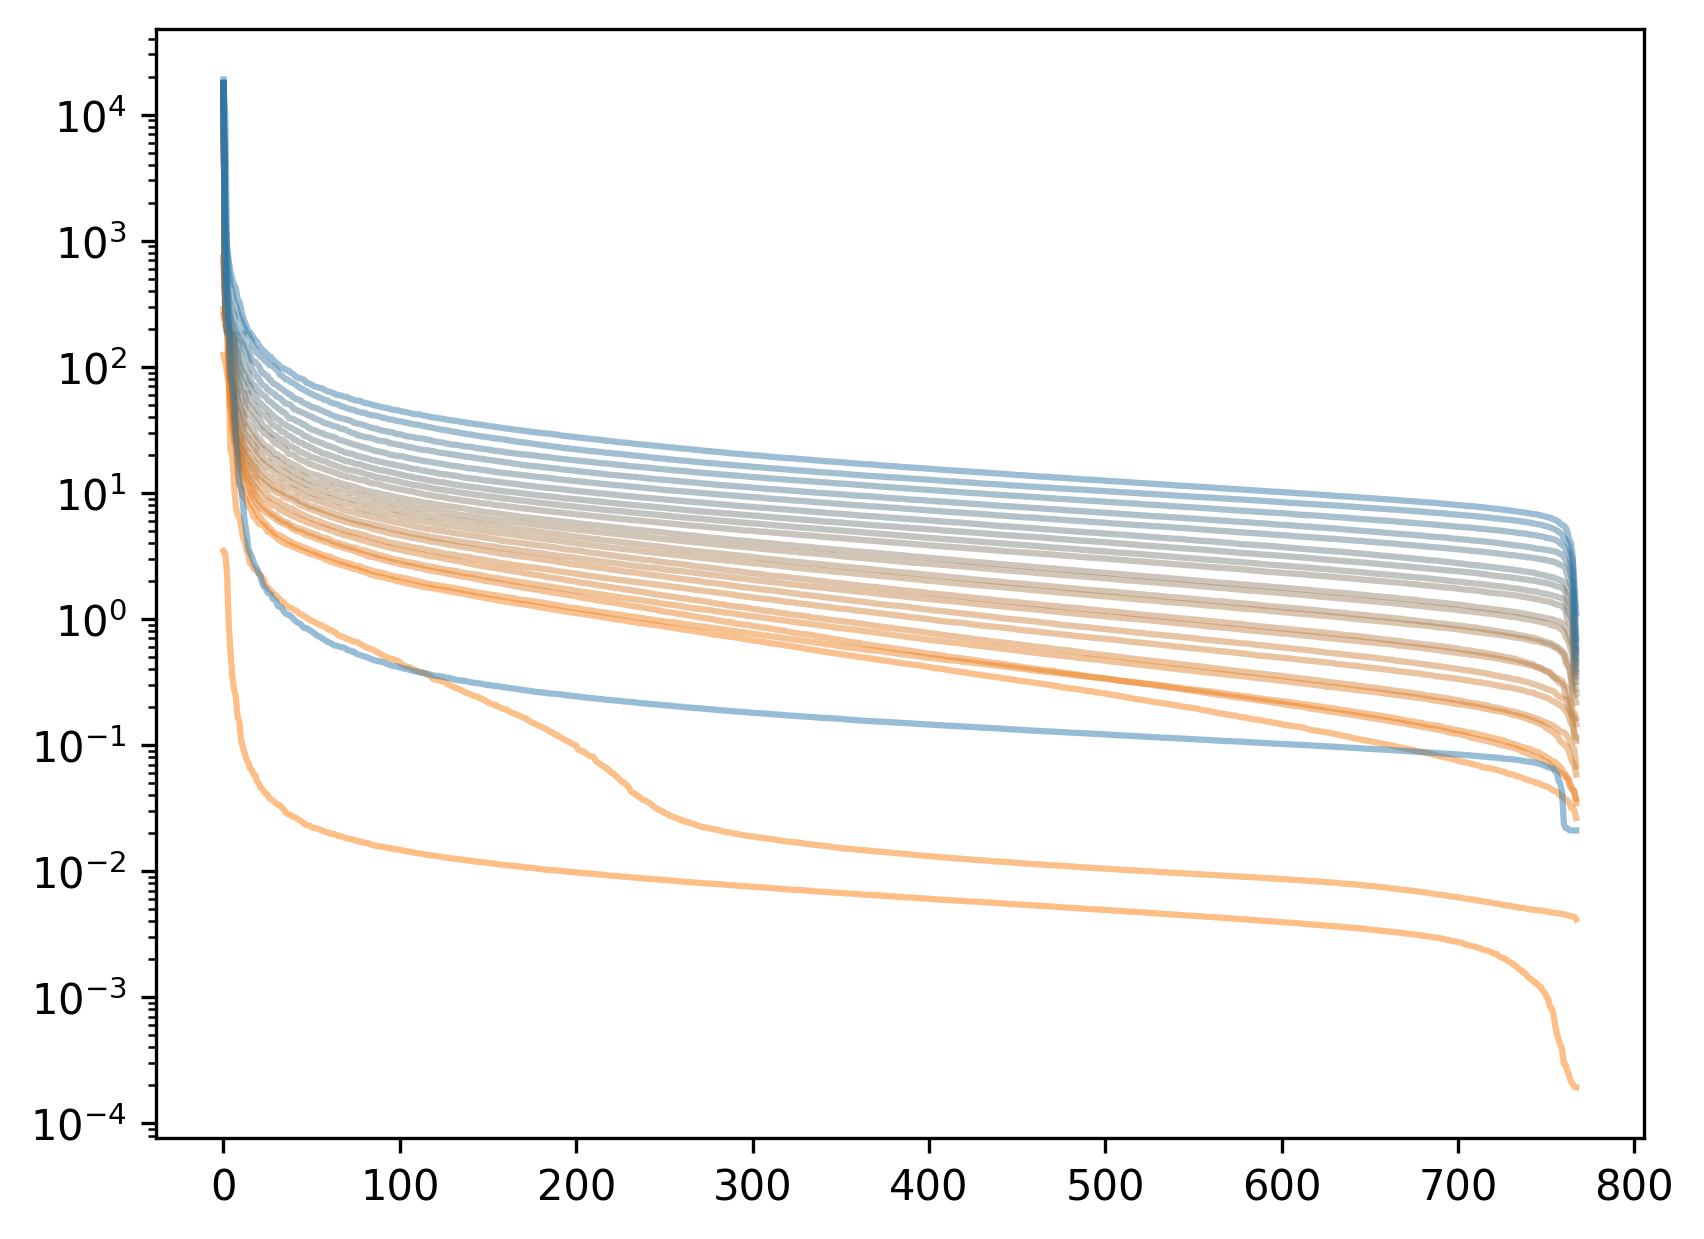

In [51]:
collector_1 = OnlineCovariance(dtype=torch.float64)
n_tokens = 1e6

i = 0
for text_index, t in enumerate(tqdm(d["train"])):
    with torch.no_grad():
        res = m.get_residual_stream(t["text"]).transpose(0, 1)

        collector_1.add_all(res)
        i += res.shape[0]
    if i > n_tokens:
        break

orig_text_index = text_index
whitener_1 = Whitener(collector_1, do_shrinkage=do_shrinkage, shrinkage_samples=n_tokens)

plt.figure()
plot_eig(collector_1, do_shrinkage=do_shrinkage)

 38%|███▊      | 3764/10000 [16:19<27:03,  3.84it/s]  


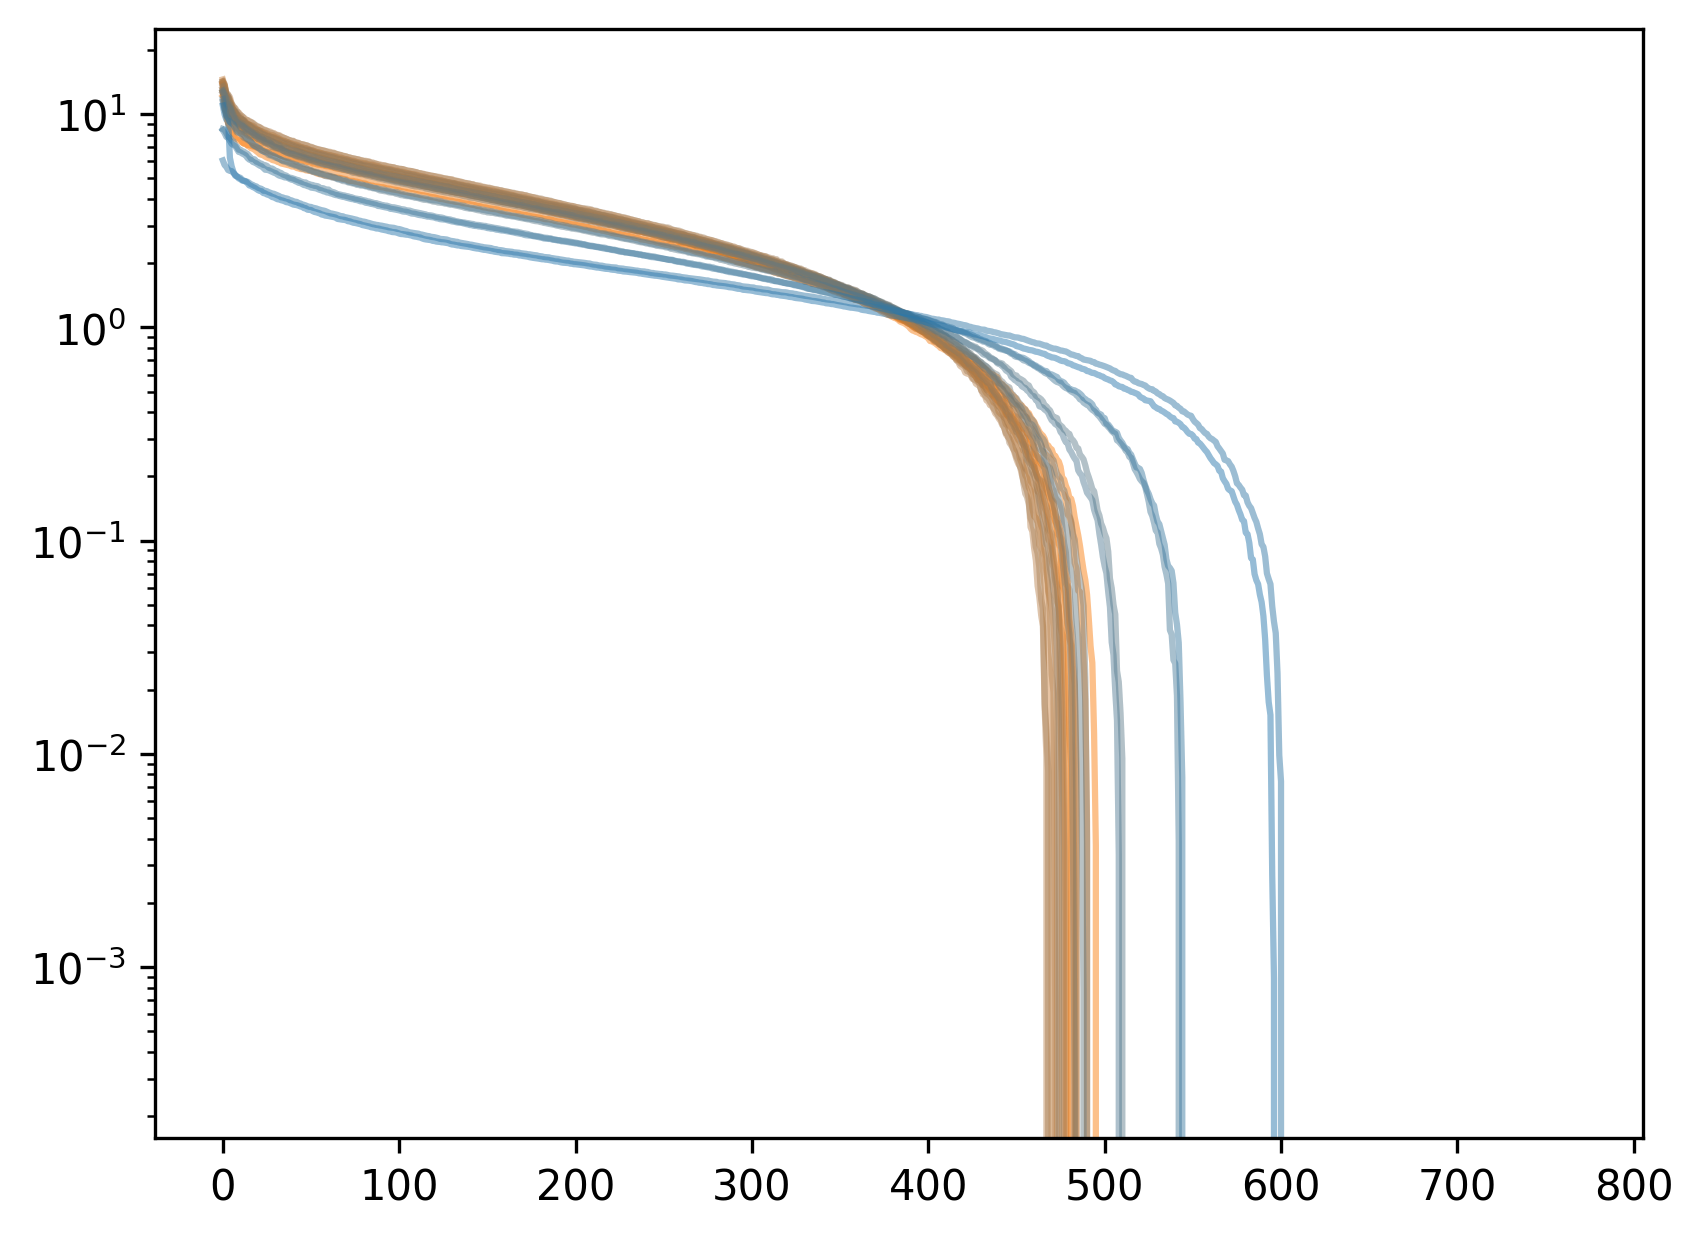

In [53]:
collector_2 = OnlineCovariance(dtype=torch.float64)
n_tokens = 1e6

i = 0
for text_index, t in enumerate(tqdm(d["train"])):
    if text_index < orig_text_index:
        continue
    with torch.no_grad():
        res = m.get_residual_stream(t["text"]).transpose(0, 1)
        collector_2.add_all(whitener_1(res))
        i += res.shape[0]
    if i > n_tokens:
        break

whitener_2 = Whitener(collector_2, do_shrinkage=do_shrinkage, shrinkage_samples=n_tokens)
whitener = combined_whitening(whitener_1, whitener_2)
plt.figure()
plot_eig(collector_2, do_shrinkage=do_shrinkage)

 56%|█████▌    | 5598/10000 [18:06<14:14,  5.15it/s]   


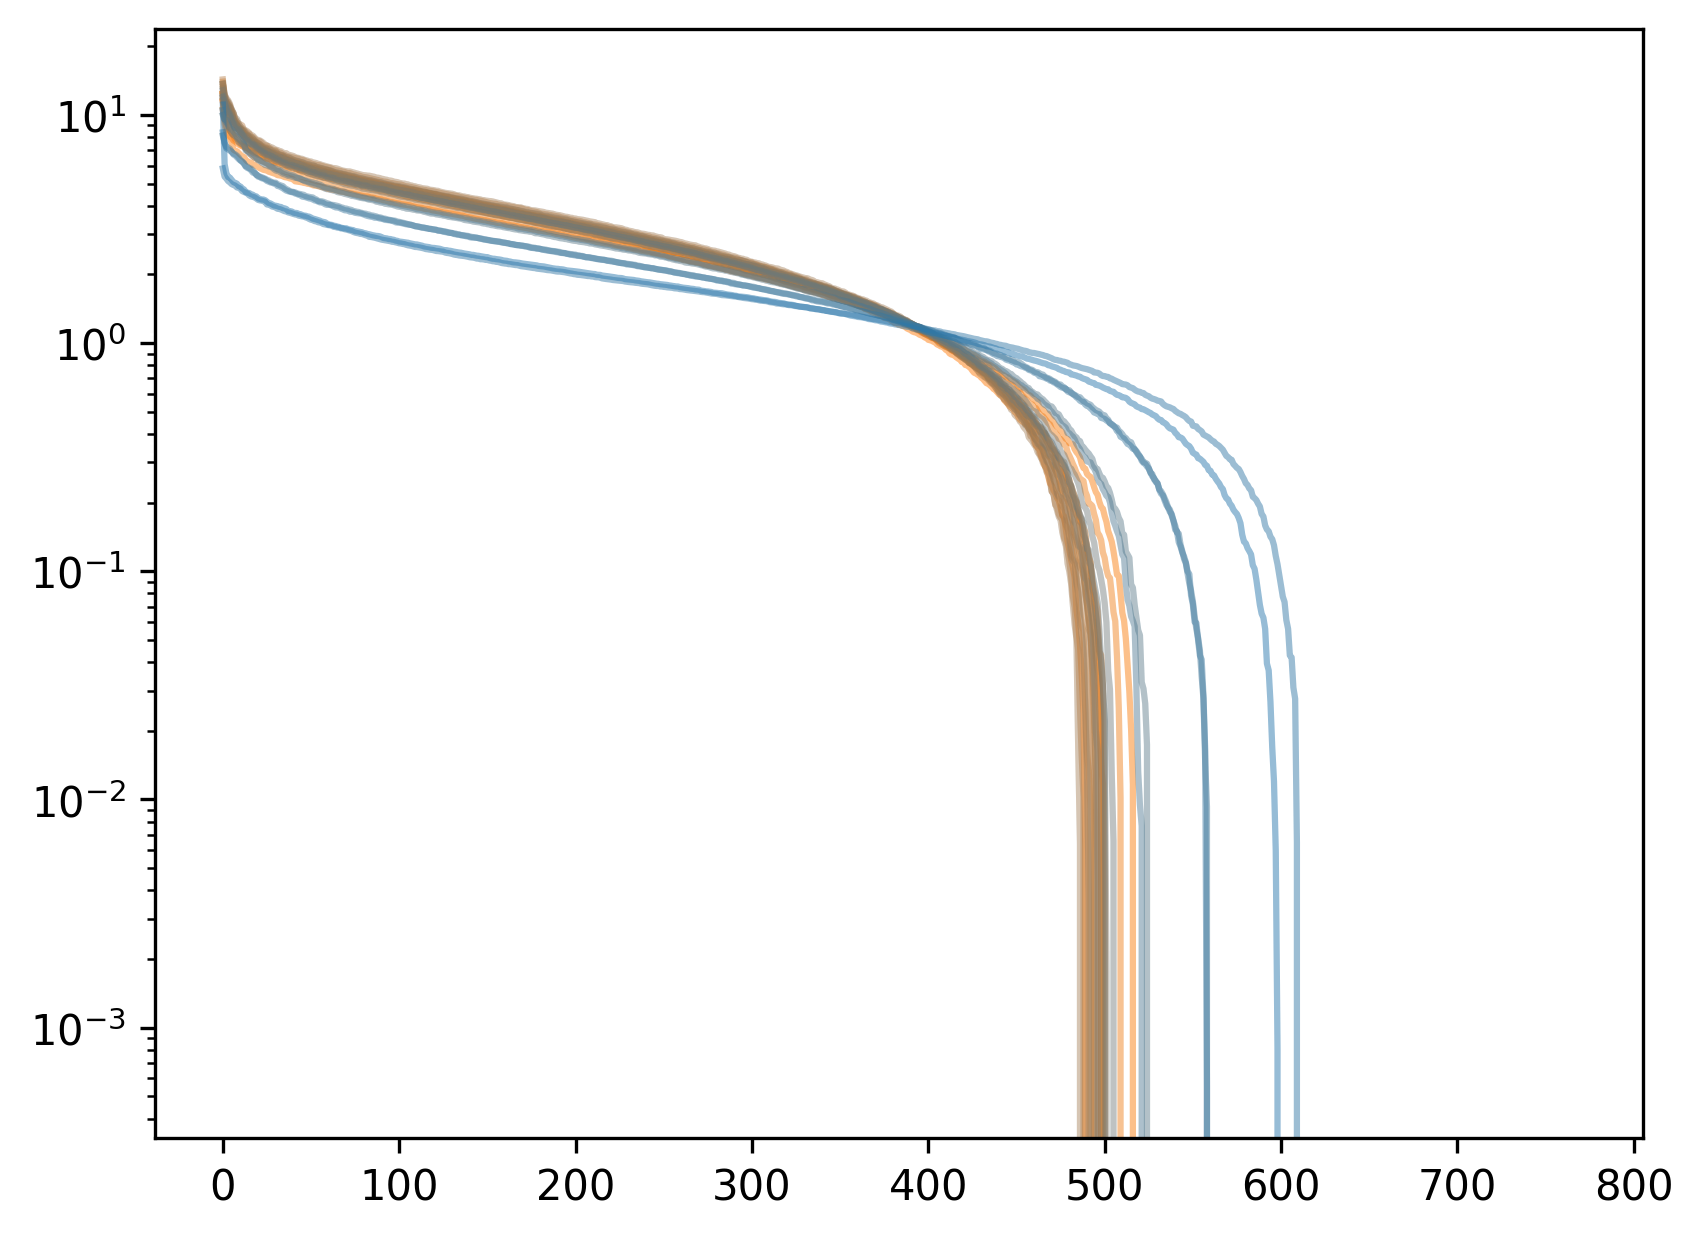

In [54]:
orig_text_index_2 = text_index

collector_3 = OnlineCovariance(dtype=torch.float64)
n_tokens = 1e6

i = 0
for text_index, t in enumerate(tqdm(d["train"])):
    if text_index < orig_text_index_2:
        continue
    with torch.no_grad():
        res = m.get_residual_stream(t["text"]).transpose(0, 1)
        collector_3.add_all(whitener_2(whitener_1(res)))
        i += res.shape[0]
    if i > n_tokens:
        break

whitener_3 = Whitener(collector_3, do_shrinkage=do_shrinkage, shrinkage_samples=n_tokens)

plot_eig(collector_3, do_shrinkage=do_shrinkage)

In [58]:
whitener = combined_whitening(whitener_1, whitener_2)
# whitener = combined_whitening(whitener, whitener_3)

In [59]:
params = {
    "W": whitener.W,
    "W_inv": whitener.W_inv,
    "mean": whitener.mean,
}
torch.save(params, "gpt2-whitener-12.pt")

In [49]:
res = m.get_residual_stream(d["train"][0]["text"]).transpose(0, 1)
print(whitener_1.W.shape, res.dtype)
print(whitener_1.W.dtype, whitener_1.W_inv.dtype, whitener_1.mean.dtype)
print(whitener_1.W.dtype, whitener_1.W_inv.dtype, whitener_1.mean.dtype)
whitener = combined_whitening(whitener_1, whitener_2)

r2 = whitener.unwhiten(whitener(res))

torch.Size([25, 768, 768]) torch.float64
torch.float64 torch.float64 torch.float64
torch.float64 torch.float64 torch.float64
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)


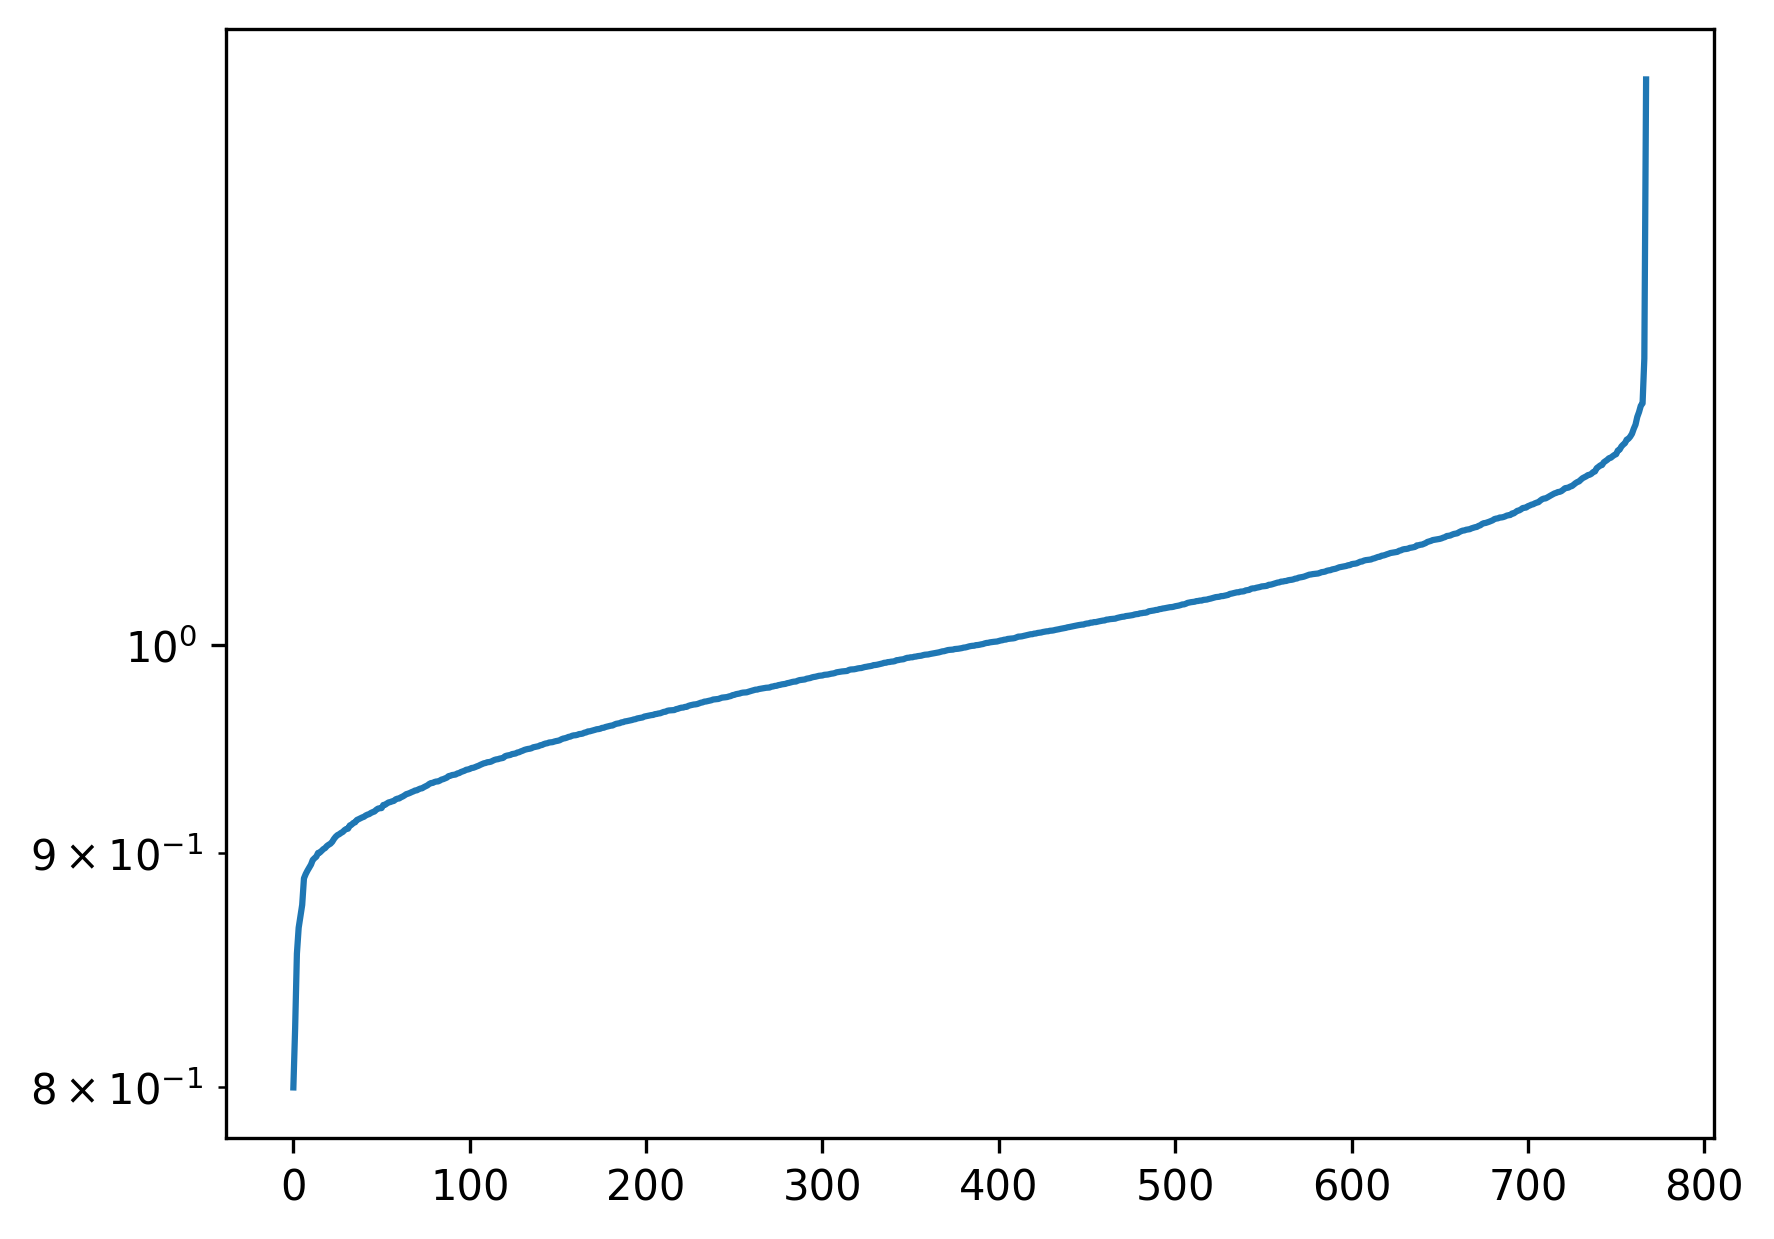

In [71]:
norms = whitener_2.W_inv.norm(dim=-2)
plt.semilogy(norms[0].cpu().numpy())

In [ ]:
class Liber:
    def __init__(self, whitener, M):
        self.whitener = whitener
        # self.M = torch.zeros_like(self.whitener.W)
        # self.device = self.M.device
        # self.M[-1, :, :] = torch.diag(torch.ones(self.whitener.W.shape[-1])).to(self.device)

    # def lib(self, res):
    #     y = self.whitener(res)
    #     y = einops.einsum(self.M, y, "... i j, ... j ->... i")
    #     y = y + self.mean.unsqueeze(0)
    #     return y

In [114]:
# n_res_layers = res_whitened.shape[0]
# print(res_whitened.shape)

lib           = torch.zeros_like(whitener_1.W)
lib[-1, :, :] = torch.eye(lib.shape[-1])
lib_inv       = lib.clone()
tokens_to_use = 1e4

m.limit = 100

for res_index in tqdm(range(n_res_layers-2, -1, -1)):
    curr_index = res_index
    next_index = res_index+1
    curr_whitener = whitener_1[curr_index]
    next_whitener = whitener_1[next_index]
    next_lib      = lib[next_index]

    i = 0
    M = Welford()

    for text in tqdm(d["train"]):
        res = m.get_residual_stream(text["text"]).transpose(0, 1)
        res_whitened = whitener_1(res).transpose(0,1)

        x = res_whitened[curr_index].requires_grad_(True)
        n_tokens, d_model = x.shape
        i += n_tokens

        # Compute the function (forward pass)
        res_func = lambda res_i : get_res_func(curr_index)(res_i.unsqueeze(0))[0]

        def func(_x):
            _y = curr_whitener.unwhiten( _x )
            _y = res_func(_y)
            _y = next_whitener.whiten( _y )
            _y = torch.nn.functional.linear( _y, next_lib )
            return _y

        y = func(x)

        J = get_jacobian(x, y)
        G = einops.einsum(J, J, "i j, i k -> j k")
        M.add( 0.5 * (G + G.T) )

        if i >= tokens_to_use:
            break

    eig_val, eig_vec = torch.linalg.eigh(
        # optimal_linear_shrinkage(M.mean, n=tokens_to_use)
        M.mean
    )

    lambda_sqrt_inv = torch.diag(1.0 / torch.sqrt(eig_val))
    lambda_sqrt     = torch.diag(torch.sqrt(eig_val))

    C     = lambda_sqrt_inv @ eig_vec.T
    C_inv = eig_vec         @ lambda_sqrt

    lib[curr_index] = C
    lib_inv[curr_index] = C_inv

    # print(curr_index, x.shape, next_index, y.shape)
    # new_res[next_index] = y

    # # Compute the Jacobian J_i_j = sum_t sum_s ( d y_i_t / d x_j_s ),
    # # where t, s are token positions
    # J_l = get_jacobian(x, y, m)

    # # Update gram matrix of jacobians
    # M_l[layer_index].add_( einops.einsum(J_l, J_l, "... i j, ... i j2 -> ... j j2") )


100%|██████████| 24/24 [17:58<00:00, 44.95s/it]


In [78]:
print(res_whitened/new_res)

tensor([[[       -inf,        -inf,        -inf,  ...,        -inf,
                 -inf,         inf],
         [       -inf,         inf,        -inf,  ...,        -inf,
                  inf,        -inf],
         [       -inf,        -inf,        -inf,  ...,        -inf,
                  inf,         inf],
         ...,
         [       -inf,        -inf,         inf,  ...,         inf,
                 -inf,        -inf],
         [        inf,         inf,         inf,  ...,         inf,
                 -inf,        -inf],
         [       -inf,         inf,         inf,  ...,         inf,
                 -inf,        -inf]],

        [[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         ...,
         [ 9.9999e-01,  9

## Testing things about gradients...

In [10]:
# m = Model("gpt2", limit=1000, dtype="fp32")
m.limit = 1000
print(m.limit )

M_l = torch.zeros(m.cfg.n_layers, m.cfg.d_model, m.cfg.d_model).detach().to(m.device)
t0 = time.time()
tokens_seen = 0

def get_jacobian(x, y, m):
    J_l = torch.zeros(m.cfg.d_model,  m.cfg.d_model).detach().to(m.device)
    for i in range(m.cfg.d_model):
        # One-hot vector to select the ith dimension
        grad_output = torch.zeros_like(y)
        grad_output[:, i] = 1

        # Calculate gradients for all tokens w.r.t to the i-th dimension of the model
        gradients = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=grad_output, only_inputs=True, retain_graph=True)[0]
        J_l[i] = gradients.mean(dim=0)  # Average over the token positions

    return J_l

for text_index in tqdm(range(100)):
    with torch.no_grad():
        text = d["train"][0]["text"]
        res = m.get_residual_stream(text)
        tokens_seen += res.shape[1]

    for res_index in range(0, m.cfg.n_layers*2, 2):
        layer_index = res_index // 2
        # Get the input
        x = res[res_index].requires_grad_(True)
        n_tokens, d_model = x.shape

        # Compute the function (forward pass)
        attn = lambda x : get_res_func(res_index)(x.unsqueeze(0))[0]
        y = attn(x)

        # Compute the Jacobian J_i_j = sum_t sum_s ( d y_i_t / d x_j_s ),
        # where t, s are token positions
        J_l = get_jacobian(x, y, m)

        # Update gram matrix of jacobians
        M_l[layer_index].add_( einops.einsum(J_l, J_l, "... i j, ... i j2 -> ... j j2") )

    print(f"{time.time() - t0:4.2f} - {tokens_seen}")
    print(M_l[0])
    break


1000


  0%|          | 0/100 [00:28<?, ?it/s]

27.96 - 1000
tensor([[ 1.1506e+02,  2.9283e+00,  2.8123e+00,  ...,  4.5771e-01,
          1.8619e-02,  5.8708e-01],
        [ 2.9283e+00,  2.8176e+01, -3.1001e+00,  ..., -1.4762e-01,
         -1.4895e+00, -2.2162e+00],
        [ 2.8123e+00, -3.1001e+00,  8.4850e+00,  ...,  6.3457e-01,
          1.7290e-01, -6.1723e-01],
        ...,
        [ 4.5771e-01, -1.4762e-01,  6.3457e-01,  ...,  4.7521e+01,
          3.6086e+00,  6.4093e+00],
        [ 1.8619e-02, -1.4895e+00,  1.7290e-01,  ...,  3.6086e+00,
          4.9749e+01,  1.4018e-03],
        [ 5.8708e-01, -2.2162e+00, -6.1723e-01,  ...,  6.4093e+00,
          1.4018e-03,  5.0846e+01]], device='cuda:0')


### Other Gradient Examples

In [11]:

import time
from tqdm import tqdm
from torch.autograd.functional import jacobian

# m = Model("gpt2", limit=1000, dtype="fp32")
m.limit = 1000
print(m.limit )

M_l = torch.zeros(m.cfg.n_layers, m.cfg.d_model, m.cfg.d_model).detach().to(m.device)
t0 = time.time()
tokens_seen = 0

def get_jacobian(func, x):
    n_tokens, d_model = x.shape
    batch_size = 10
    J = torch.zeros(d_model,  d_model).detach().to(y.device)

    for i in range(0, m.cfg.d_model, batch_size):
        batch_func = lambda x: func(x.unsqueeze(0))[0][..., i:i+batch_size]
        J_i = torch.autograd.functional.jacobian(func, x, create_graph=False, strict=False, vectorize=False, strategy='reverse-mode')
        print(J_i.shape)

        J[i:i+batch_size] = J_i

    return J_l

    # Update gram matrix of jacobians
    M_l[layer_index].add_( einops.einsum(J_l, J_l, "... i j, ... i j2 -> ... j j2") )

for text_index in tqdm(range(100)):
    with torch.no_grad():
        text = d["train"][0]["text"]
        res = m.get_residual_stream(text)
        tokens_seen += res.shape[1]

    for res_index in range(0, m.cfg.n_layers*2, 2):
        layer_index = res_index // 2
        attn = lambda x : get_res_func(res_index)(x.unsqueeze(0))[0]
        x = res[res_index].requires_grad_(True)
        J = get_jacobian(func=attn, x=x)
        M_l[layer_index].add_( einops.einsum(J, J, "... i j, ... i j2 -> ... j j2") )

    print(f"{time.time() - t0:4.2f} - {tokens_seen}")
    print(M_l[0])
    break


1000


  0%|          | 0/100 [00:13<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 46.00 MiB. GPU 0 has a total capacity of 15.73 GiB of which 31.12 MiB is free. Including non-PyTorch memory, this process has 15.69 GiB memory in use. Of the allocated memory 14.71 GiB is allocated by PyTorch, and 767.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

import time
from tqdm import tqdm
# m = Model("gpt2", limit=1000, dtype="fp32")
m.limit = 1000
print(m.limit )

M_l = torch.zeros(m.cfg.n_layers, m.cfg.d_model, m.cfg.d_model).detach().to(m.device)
t0 = time.time()
tokens_seen = 0

def get_jacobian(x, y):
    d_model = y.shape[1]

    # Create an identity matrix to select all dimensions
    grad_output = torch.eye(d_model).to(y.device)

    # Calculate gradients for all tokens w.r.t to all dimensions of the model
    gradients = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=grad_output, only_inputs=True, retain_graph=True)[0]

    # Average over the token positions
    J_l = gradients.mean(dim=0)

    return J_l

def get_jacobian(x, y):
    d_model = y.shape[1]
    n_tokens = y.shape[0]
    grad_output = torch.eye(n_tokens, d_model).to(y.device)
    gradients = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=grad_output, only_inputs=True, retain_graph=True)[0]
    J_l = gradients.mean(dim=0)
    return J_l

def get_jacobian(x, y, m):
    J_l = torch.zeros(m.cfg.d_model,  m.cfg.d_model).detach().to(m.device)
    for i in range(m.cfg.d_model):
        # One-hot vector to select the ith dimension
        grad_output = torch.zeros_like(y)
        grad_output[:, i] = 1

        # Calculate gradients for all tokens w.r.t to the i-th dimension of the model
        gradients = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=grad_output, only_inputs=True, retain_graph=True)[0]
        J_l[i] = gradients.mean(dim=0)  # Average over the token positions

    return J_l



for text_index in tqdm(range(100)):
    with torch.no_grad():
        text = d["train"][0]["text"]
        res = m.get_residual_stream(text)
        tokens_seen += res.shape[1]

    for res_index in range(0, m.cfg.n_layers*2, 2):
        layer_index = res_index // 2
        # Get the input
        x = res[res_index].requires_grad_(True)
        n_tokens, d_model = x.shape

        # Compute the function (forward pass)
        attn = lambda x : get_res_func(res_index)(x.unsqueeze(0))[0]
        y = attn(x)

        # Compute the Jacobian J_i_j = sum_t sum_s ( d y_i_t / d x_j_s ),
        # where t, s are token positions
        J_l = get_jacobian(x, y)

        # Update gram matrix of jacobians
        M_l[layer_index].add_( einops.einsum(J_l, J_l, "... i j, ... i j2 -> ... j j2") )

    print(f"{time.time() - t0:4.2f} - {tokens_seen}")
    print(M_l[0])
    break


1000


  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: einsum(): the number of subscripts in the equation (2) is more than the number of dimensions (1) for operand 0

In [ ]:

import time
from tqdm import tqdm
m.limit = 1000
print(m.limit )

M_l = torch.zeros(m.cfg.n_layers, m.cfg.d_model, m.cfg.d_model).detach().to(m.device)
J_l = torch.zeros(m.cfg.d_model,  m.cfg.d_model).detach().to(m.device)
t0 = time.time()
tokens_seen = 0
for text_index in tqdm(range(100)):
    with torch.no_grad():
        text = d["train"][0]["text"]
        res = m.get_residual_stream(text)
        tokens_seen += res.shape[1]

    for res_index in range(0, m.cfg.n_layers*2, 2):
        layer_index = res_index // 2
        # Get the input
        x = res[res_index].requires_grad_(True)
        n_tokens, d_model = x.shape

        # Compute the function (forward pass)
        attn = lambda _x : get_res_func(res_index)(_x.unsqueeze(0))[0]
        y = attn(x)


        # Batch size for the dimension; choose an appropriate value that fits your memory
        batch_size = 128

        # Compute gradients in batches
        for i in range(0, d_model, batch_size):
            # Indices of the current batch
            batch_indices = slice(i, min(i + batch_size, d_model))

            # Create a matrix for vector-Jacobian product of the current batch
            # The identity matrix selects a subset of dimensions
            eye_batch = torch.eye(d_model)[:, batch_indices].to(x.device)

            # Perform the vector-Jacobian product
            # We don't need to retain the graph after the last batch
            retain_graph = i + batch_size < d_model
            grads = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=eye_batch,
                                        retain_graph=retain_graph, create_graph=False)[0]

            # Average gradients over the tokens and accumulate
            # M_l[batch_indices] = grads.mean(dim=0)
            J_l[batch_indices] = grads.mean(dim=0)  # Average over the token positions

        # Update gram matrix of jacobians
        M_l[layer_index].add_( einops.einsum(J_l, J_l, "... i j, ... i j2 -> ... j j2") )

        # M_l now contains the average interaction between all dimensions of the model
        # across all tokens, with memory efficiency

1000


  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'get_res_func' is not defined

In [ ]:

import torch
from torch.autograd.functional import jacobian

from tqdm import tqdm
m.limit = 50
print(m.limit)

for text_index in tqdm(range(100)):
    res_index = 0
    with torch.no_grad():
        text = d["train"][0]["text"]
        x = m.get_residual_stream(text)[res_index]
    x = x.requires_grad_(True)
    n_tokens, d_model = x.shape

    # Compute the function (forward pass)
    attn = lambda _x : get_res_func(res_index)(_x.unsqueeze(0))
    y = attn(x)

    # Calculate the full Jacobian matrix efficiently
    J = jacobian(attn, x)

    # M^l is now simply the mean of the outer product of the Jacobian matrix across tokens
    M_l = torch.einsum('ntki,ntkj->ij', J, J) / n_tokens

    # Now M_l is the [d_model, d_model] matrix representing the average interaction across all tokens



50


  0%|          | 0/100 [00:19<?, ?it/s]


RuntimeError: einsum(): the number of subscripts in the equation (4) does not match the number of dimensions (5) for operand 0 and no ellipsis was given

In [ ]:
print(J.shape)

torch.Size([1, 50, 768, 50, 768])


### Toy Linear Jacobian

In [ ]:
import torch
x = torch.randn([5, 3])
W = torch.nn.Linear(3,3)

In [ ]:
print(x, W(x))

tensor([[ 0.6886,  1.6500, -1.1011],
        [ 0.6316, -1.9199,  0.6340],
        [-0.2881,  0.0674, -1.1272],
        [-0.6801,  0.9151,  1.3548],
        [-1.0585, -1.1333,  1.4989]]) tensor([[-0.0700, -0.0898, -1.3239],
        [ 0.9267,  0.3417,  1.0510],
        [-0.1491,  0.2484, -0.4912],
        [-0.2196,  0.1694,  0.4015],
        [ 0.0955,  0.4772,  1.4144]], grad_fn=<AddmmBackward0>)


In [ ]:
def eye_expand(y):
    n_samples, d_vec = y.shape
    identity = torch.eye(d_vec)

    # Step 2: Expand this identity matrix to [n_samples, d_vec, d_vec]
    expanded_identity = identity.unsqueeze(0).expand(n_samples, -1, -1)
    y_expanded = y.unsqueeze(2).expand(-1, -1, d_vec)
    return ( y_expanded * expanded_identity ), expanded_identity

def get_jacobian(x, y):
    d_model = 3
    J_l = torch.zeros(d_model, d_model).detach().to(y.device)
    for i in range(d_model):
        # One-hot vector to select the ith dimension
        grad_output = torch.zeros_like(y)
        grad_output[:, i] = 1

        # Calculate gradients for all tokens w.r.t to the i-th dimension of the model
        gradients = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=grad_output, only_inputs=True, retain_graph=True)[0]
        J_l[i] = gradients.mean(dim=0)  # Average over the token positions

    return J_l

def get_jacobian(x, y):
    # d_model = 3
    # J_l = torch.zeros(d_model, d_model).detach().to(y.device)
    # One-hot vector to select the ith dimension
    y_expanded, eye = eye_expand(y)
    grad_output = eye
    print(eye.shape)
    # grad_output[:, i] = 1

    # Calculate gradients for all tokens w.r.t to the i-th dimension of the model
    gradients = torch.autograd.grad(outputs=y_expanded, inputs=x, grad_outputs=grad_output, only_inputs=True, retain_graph=True)[0]
    print(gradients.shape)
    J_l = gradients.mean(dim=0)  # Average over the token positions

    return J_l

def get_jacobian(x, y, batch_size=3):
    d_model = y.shape[-1]
    J_l = torch.zeros(d_model, d_model).detach().to(y.device)
    for i in range(0, d_model, batch_size):
        end = i + batch_size
        if end > d_model:
            end = d_model
        current_batch_size = end - i

        # Create batched one-hot vectors to select multiple dimensions
        grad_output = torch.zeros_like(y)
        # Ensuring we only populate up to the number of dimensions available
        grad_output[:, i:end] = torch.eye(current_batch_size, device=y.device)

        # Calculate gradients for the batch
        gradients = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=grad_output, only_inputs=True, retain_graph=True)[0]
        J_l[i:end] = gradients.mean(dim=0)  # Average over the batch dimensions, store results

    return J_l

def get_jacobian(x, y):
    # Assume y has shape [batch_size, d_model] and x has shape [batch_size, d_vec]
    batch_size, d_model = y.shape
    _, d_vec = x.shape

    # Create an identity matrix of shape [d_model, d_model]
    eye = torch.eye(d_model).repeat(batch_size, 1, 1).to(y.device)  # Shape [batch_size, d_model, d_model]

    # Expand y to [batch_size, d_model, d_model] for batched gradient computation
    y_expanded = y.unsqueeze(2).expand(-1, -1, d_model)

    # Calculate gradients for all elements in the batch w.r.t each dimension of the model
    grad_outputs = eye  # Shape matches y_expanded for batched gradients

    # Compute gradients
    gradients = torch.autograd.grad(outputs=y_expanded, inputs=x, grad_outputs=grad_outputs,
                                    only_inputs=True, retain_graph=True, create_graph=True)[0]

    # Gradients shape [batch_size, d_vec, d_model]; we need to transpose the last two dimensions
    # and take the mean over the batch to get the final Jacobian shape [d_model, d_vec]
    J = gradients.mean(dim=0).transpose(0, 1)  # Shape [d_model, d_vec]

    return J

x = x.requires_grad_(True)
y = W(x)
print(get_jacobian(x, y))

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
print(W.weight)

Parameter containing:
tensor([[ 0.4472, -0.2280,  0.1201],
        [-0.1443, -0.1245, -0.0121],
        [-0.1695, -0.4295,  0.4795]], requires_grad=True)
